In [1]:
import os
import csv

# 指定输入和输出文件夹路径
input_folder = 'input_csv_folder'
output_file = 'merged_data_sorted.csv'

# 创建一个集合来存储数据
merged_data_unique = set()

# 遍历指定文件夹中的所有文件
for filename in os.listdir(input_folder):
    if filename.endswith('.csv'):
        file_path = os.path.join(input_folder, filename)
        # 读取每个 CSV 文件中的数据
        with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
            reader = csv.reader(csvfile)
            # 跳过第一行（标题行）
            next(reader)
            # 将每行数据加入到集合中
            for row in reader:
                merged_data_unique.add(tuple(row))

# 将集合中的数据转换为列表
merged_data_list = list(merged_data_unique)

# 根据 'log_time' 列进行顺序排序
merged_data_sorted = sorted(merged_data_list, key=lambda x: x[4])

# 将整理后的数据写入新的 CSV 文件
# 设置输出文件夹与文件名
output_folder = 'output_csv_folder'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
output_file = os.path.join(output_folder, 'merged_data_sorted.csv')

# 写入 CSV 文件
with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # 写入标题行
    writer.writerow(['node_name', 'rate', 'origin_traffic', 'traffic', 'log_time'])
    # 逐行写入数据
    for row in merged_data_sorted:
        writer.writerow(row)

print(f"Sorted and unique merged data has been saved to '{output_file}'")


Sorted and unique merged data has been saved to 'output_csv_folder/merged_data_sorted.csv'


In [6]:
import csv
from collections import defaultdict
from datetime import datetime, timedelta
import operator

# Data storage dictionary
node_traffic = defaultdict(float)
traffic_statistics = defaultdict(lambda: defaultdict(float))

# Read the CSV file and perform traffic statistics

output_folder = 'output_csv_folder'
file = os.path.join(output_folder, 'merged_data_sorted.csv')
with open(file, newline='') as csvfile:
    reader = csv.reader(csvfile)
    # Skip the header
    next(reader)
    for row in reader:
        # Parse the timestamp
        log_time = datetime.strptime(row[4], '%Y-%m-%d %H:%M:%S')

        # Extract traffic data and convert to MB
        traffic = row[3]
        if traffic.endswith('KB'):
            traffic_mb = float(traffic[:-2]) / 1024
        elif traffic.endswith('MB'):
            traffic_mb = float(traffic[:-2])
        elif traffic.endswith('GB'):
            traffic_mb = float(traffic[:-2]) * 1024
        elif traffic.endswith('B'):
            traffic_mb = float(traffic[:-1]) / (1024 * 1024)
        else:
            traffic_mb = 0

        # Accumulate traffic for each node and time period
        node_traffic[row[0]] += traffic_mb
        # Consider only the last 168 hours of data
        if log_time >= datetime.now() - timedelta(hours=168):
            # Round the timestamp to the nearest three hours
            log_time = log_time - timedelta(hours=log_time.hour % 3, minutes=log_time.minute, seconds=log_time.second)
            # Accumulate traffic
            traffic_statistics[row[0]][log_time] += traffic_mb

# Convert the statistics into a sorted list
sorted_traffic = sorted(traffic_statistics.items(), key=lambda x: sum(x[1].values()), reverse=True)

# Get all unique time periods
all_time_periods = set()
for node_data in traffic_statistics.values():
    all_time_periods.update(node_data.keys())

# Sort time periods
sorted_time_periods = sorted(all_time_periods)


output_folder = 'output_csv_folder'
output_file1 = os.path.join(output_folder, 'traffic_summary.csv')

# Write the results to a CSV file
with open(output_file1, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write the header row
    header_row = ['Time Period'] + list(node_traffic.keys())
    writer.writerow(header_row)

    # Write the traffic for each time period
    for time_period in sorted_time_periods:
        traffic_values = []
        for node_name in node_traffic.keys():
            traffic_values.append(f'{traffic_statistics[node_name][time_period]:.2f}' if time_period in traffic_statistics[node_name] else '0.00')
        writer.writerow([time_period.strftime('%Y-%m-%d %H:%M')] + traffic_values)

print("Traffic summary has been saved to 'traffic_summary.csv'")


Traffic summary has been saved to 'traffic_summary.csv'


In [7]:
import csv
from collections import defaultdict

# Read the traffic summary CSV file


traffic_summary = []

output_folder = 'output_csv_folder'
file = os.path.join(output_folder, 'traffic_summary.csv')

with open(file, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        traffic_summary.append(row)

# Calculate total traffic for each node
node_traffic_totals = defaultdict(float)
for row in traffic_summary[1:]:
    for i, traffic in enumerate(row[1:], start=1):
        node_traffic_totals[traffic_summary[0][i]] += float(traffic)

# Insert a new row after the first row with total traffic for each node
total_traffic_row = ['Total Traffic'] + [str(node_traffic_totals[node]) for node in traffic_summary[0][1:]]
traffic_summary.insert(1, total_traffic_row)

# Filter out nodes with total traffic less than 10MB
filtered_nodes = [node for node, total_traffic in node_traffic_totals.items() if total_traffic >= 10]

# Rearrange traffic summary based on filtered nodes
sorted_traffic_summary = []
for col_idx, col_data in enumerate(zip(*traffic_summary)):
    if col_idx == 0 or col_data[0] in filtered_nodes:
        sorted_traffic_summary.append(list(col_data))

# Rearrange traffic summary based on filtered nodes and transpose the matrix
sorted_traffic_summary_transposed = []

# Transpose the data except for the first row and first column
for i, row in enumerate(sorted_traffic_summary):
    if i == 0:  # Preserve the first row
        sorted_traffic_summary_transposed.append(row)
    else:
        transposed_row = [row[0]] + [f'{float(value):.2f}' for value in row[1:]]  # Preserve the first column, convert the rest to floats
        sorted_traffic_summary_transposed.append(transposed_row)

# Write the sorted and filtered traffic summary to a new CSV file
output_folder = 'output_csv_folder'
output_file2 = os.path.join(output_folder, 'sorted_traffic_summary.csv')

with open(output_file2, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(zip(*sorted_traffic_summary_transposed))

print("Sorted and filtered traffic summary has been saved to 'sorted_traffic_summary.csv'")


Sorted and filtered traffic summary has been saved to 'sorted_traffic_summary.csv'


In [9]:
import pandas as pd
import csv
from collections import defaultdict
from datetime import datetime, timedelta

# 读取并整理数据
daily_traffic = defaultdict(lambda: defaultdict(float))  # 以天为键，存储每天每个节点的流量消耗

output_folder = 'output_csv_folder'
file = os.path.join(output_folder, 'merged_data_sorted.csv')

with open(file, 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # 跳过标题行
    for row in reader:
        node_name, rate, origin_traffic, traffic, log_time = row
        # 解析日期时间并提取日期部分
        log_date = datetime.strptime(log_time, '%Y-%m-%d %H:%M:%S').date()
        # 处理流量数据
        if traffic.endswith('GB'):
            traffic_mb = float(traffic[:-2]) * 1024
        elif traffic.endswith('MB'):
            traffic_mb = float(traffic[:-2])
        elif traffic.endswith('KB'):
            traffic_mb = float(traffic[:-2]) / 1024
        elif traffic.endswith('B'):
            traffic_mb = float(traffic[:-1]) / 1024 / 1024
        else:
            raise ValueError("Invalid traffic unit")

        # 累加每天每个节点的流量消耗
        daily_traffic[log_date][node_name] += traffic_mb

# 创建整合的数据框
columns = ['Date', 'Total Traffic(MB)']
for i in range(1, 6):
    columns.extend([f'Rank-{i}-Node', f'Traffic-{i}(MB)'])

merged_data = []

# 生成整合的数据
for date, node_traffic in daily_traffic.items():
    
    day_data = [date, round(sum(node_traffic.values()), 2)]

    # 获取流量前五的节点
    sorted_nodes = sorted(node_traffic.items(), key=lambda x: x[1], reverse=True)[:5]

    # 按照格式添加节点名称和流量消耗量
    for node, traffic in sorted_nodes:
        day_data.extend([node, round(traffic, 2)])

    # 添加到整合数据中
    merged_data.append(day_data)

# 将merged_data根据日期倒序排列

merged_data = sorted(merged_data, key=lambda x: x[0], reverse=True)

# 将整合的数据写入 CSV 文件

output_folder = 'output_csv_folder'
output_file3 = os.path.join(output_folder, 'daily_traffic_summary.csv')

with open(output_file3, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(columns)  # 写入标题行
    writer.writerows(merged_data)  # 写入数据

print("Daily traffic summary has been saved to 'daily_traffic_summary.csv'")




Daily traffic summary has been saved to 'daily_traffic_summary.csv'


TypeError: can't multiply sequence by non-int of type 'float'

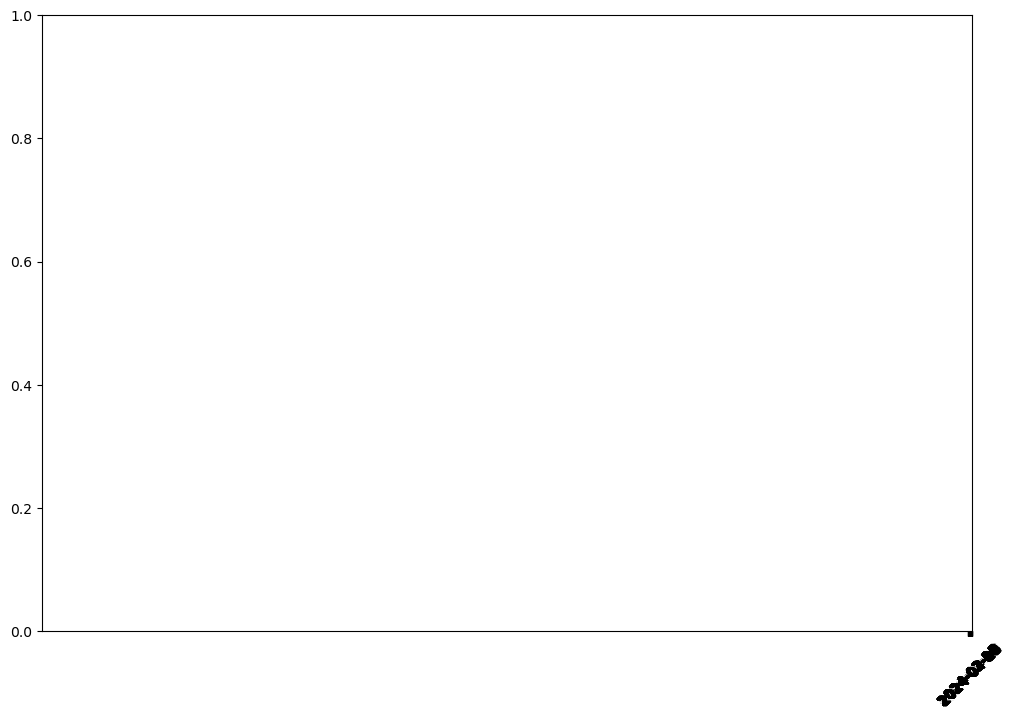

In [10]:
# 绘制过去七日的流量柱状图。横坐标为日期，纵坐标为不同节点的流量消耗，不同节点使用不同颜色标记，在柱状图中叠加

import matplotlib.pyplot as plt

# 读取数据
file = os.path.join(output_folder, 'daily_traffic_summary.csv')

with open(file, 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # 跳过标题行
    data = [row for row in reader]


# 绘制柱状图
fig, ax = plt.subplots(figsize=(12, 8))

# 设置横坐标
dates = [datetime.strptime(d[0], '%Y-%m-%d').date() for d in data]
ax.set_xticks(dates)
ax.set_xticklabels([d.strftime('%Y-%m-%d') for d in dates], rotation=45)


# 设置纵坐标
y_max = max(max(d[1:]) for d in data)
ax.set_ylim(0, y_max * 1.1)
ax.set_ylabel('Traffic(MB)')


# 设置颜色
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


# 绘制柱状图
for i in range(1, 6):
    node_names = [d[i*2] for d in data]
    node_traffic = [d[i*2+1] for d in data]
    ax.bar(dates, node_traffic, bottom=[sum(d[1:i*2+1]) for d in data], color=colors[:len(node_names)], label=f'Rank-{i}-Node')


# 显示图例
ax.legend()

# 保存图表
output_file4 = os.path.join(output_folder, 'daily_traffic_summary.png')
plt.savefig(output_file4)


print("Daily traffic summary has been saved to 'daily_traffic_summary.png'")